In [1]:
from numpy import * 

平方误差可以写作：
$$\sum_{i=1}^{n}(y_{i}-x^{T}_{i}w)^{2}$$
用矩阵表示可以写作：
$$(y-Xw)^{T}(y-Xw)$$
对 w 求导得到: $$X^{T}(Y-Xw)$$ 令其为0 解出w 如下$$w = (X^{T}X)^{-1}X^{T}y$$

## 标准回归

In [86]:
# 导入数据
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t')) - 1
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat 

# 标准回归函数
def standRegres(xArr, yArr):
    xMat = mat(xArr); yMat=mat(yArr).T
    xTx = xMat.T * xMat 
    if linalg.det(xTx) == 0:
        print("The matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T * yMat)
    return ws 

xArr, yArr = loadDataSet('ex0.txt')
ws = standRegres(xArr, yArr)
ws

matrix([[3.00774324],
        [1.69532264]])

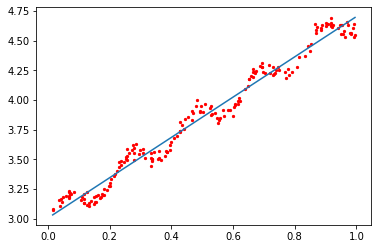

In [162]:
# 绘图
import matplotlib.pyplot as plt 

xMat = mat(xArr); yMat = mat(yArr)
yHat = xMat * ws
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0], yMat.T[:,0].flatten().A[0], s=5, c='red')

xCopy = xMat.copy()
xCopy.sort(0)
yHat = xCopy * ws 
ax.plot(xCopy[:,1], yHat)

In [97]:
# 判断模型好坏
# 计算预测值 yHat 与真实值 y之间的相关系数
corrcoef((xMat*ws).T, yMat)

array([[1.        , 0.98647356],
       [0.98647356, 1.        ]])

### 局部加权线性回归 LWLR （ Locally Weighted Linear Regression）
线性回归可能出现欠拟合现象，因为它求的是最小均方误差的无偏估计。

在预测点附近的每个点赋予一定的权重，回归系数形式：$$ w = (X^{T}WX)^{-1}X^{T}Wy $$ 
LWLR 使用“核”（与支持向量机中的核类似）来对附近点赋予更高的权重，常用高斯核，高斯核对应权重如下：
$$w(i,i) = exp\left(\frac{|x^{(i)}-x|}{-2k^{2}}\right)$$
这样构建了一个只含对角元素的权重矩阵 w，且x 与 x(i) 越近，w(i,i)越大

In [164]:
def lwlr(testpoint, xArr, yArr, k=1.0):
    xMat = mat(xArr); yMat = mat(yArr).T
    m = shape(xMat)[0]
    weights = mat(eye((m)))
    for j in range(m):
        diffMat = testpoint - xMat[j, :]
        weights[j, j] = exp(diffMat * diffMat.T / (-2.0*k**2))
    xTx = xMat.T * (weights * xMat)
    if linalg.det(xTx) == 0:
        print("The matrix is singular, cannot do inverse")
        return 
    ws = xTx.I*xMat.T*weights*yMat
    return testpoint * ws

def lwlrTest(testArr, xArr, yArr, k=1.0):
    m = shape(testArr)[0]
    yHat = zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i], xArr, yArr, k)
    return yHat

[[3.12204471]]


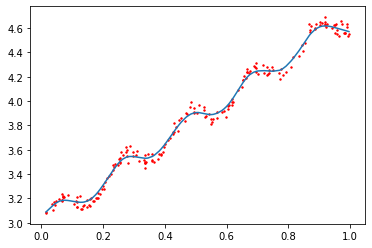

In [169]:
xArr, yArr = loadDataSet('ex0.txt')

# 对单点进行估计
print(lwlr(xArr[0], xArr, yArr))

# 得到所有估计
yHat = lwlrTest(xArr, xArr, yArr, 0.03)

# 绘图
xMat = mat(xArr)
srtInd = xMat[:,1].argsort(0)
xSort = xMat[srtInd][:, 0, :]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xSort[:,1], yHat[srtInd])
xMat[:,1].flatten().A[0]
ax.scatter(xMat[:,1].flatten().A[0], mat(yArr).T.flatten().A[0], s=2, c='red')

### 岭回归
简介：在矩阵 x.Tx 上加上一个 lambda*I 从而是的矩阵非奇异。回归计算变为
$$w = (X^{T}X + \lambda I)^{-1}x^{T}y$$

岭回归最先用来处理特征多余样本的情况，现在也用于在估计加入偏差，从而得到更好的估计。

这里通过引入 lambda 限制所有 w 之和，能够减少不重要参数，这个在统计学上叫做缩减

In [175]:
def ridgeRegres(xMat, yMat, lam=0.2):
    xTx = xMat.T * xMat
    denom = xTx + eye(shape(xMat)[1]) * lam 
    if linalg.det(denom) == 0:
        print("This matrix is singular, cannot do inverse")
        return 
    ws = denom.I * (xMat.T * yMat)
    return ws 

def ridgeTest(xArr, yArr):
    xMat = mat(xArr); yMat = mat(yArr).T
    yMean = mean(yMat, 0)
    yMat = yMat - yMean
    xMeans = mean(xMat, 0)
    xVar = var(xMat, 0)
    xMat = (xMat - xMeans) / xVar
    numTestPts = 30
    wMat = zeros((numTestPts, shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xMat, yMat, exp(i-10))
        wMat[i, :] = ws.T 
    return wMat 

No handles with labels found to put in legend.


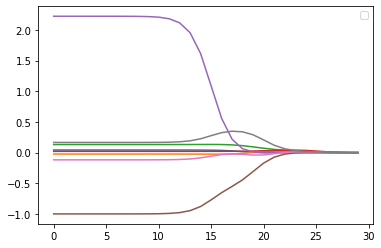

In [180]:
abX, abY = loadDataSet('abalone.txt')
ridgeWeights = ridgeTest(abX, abY)
# print(ridgeWeights)

# 绘图（查看缩减效果）
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ridgeWeights)
ax.legend()

岭回归的回归系数变化图

lambda 很小时，系数与普通回归一样，lambda 很大时，所有回归系数缩减为0，可以在中间某处找到使结果最好的 lambda

### 前向逐步回归
* 可以得到与 Lasso 差不多的效果，单更简单，属于一种贪心算法，即每一步都尽可能减小误差，一开始所有权重都设为1，然后每一步的决策都是对某个权重增加或减少一个很小的值
* 主要优点在于可以帮助人们理解现有模型并做出改进。当构建一个模型后，可以运行该算法找出重要特征

In [195]:
def regularize(xMat):
    inMat = xMat.copy()
    inMeans = mean(inMat, 0)
    inVar = var(inMat, 0)
    inMat = (inMat - inMeans) / inVar
    return inMat

def rssError(yArr, yHat):
    return ((yArr-yHat)**2).sum()

def stageWise(xArr, yArr, eps=0.01, numIt=100):
    xMat = mat(xArr); yMat = mat(yArr).T
    yMean = mean(yArr)
    yMat = yMat - yMean 
    xMat = regularize(xMat)
    m,n = shape(xMat)
    returnMat = zeros((numIt, n))
    ws = zeros((n,1)); wsTest = ws.copy(); wsMax = ws.copy()
    for i in range(numIt):
        print(ws.T)
        lowestError = inf;
        for j in range(n):
            for sign in [-1,1]:
                wsTest = ws.copy()
                wsTest[j] += eps * sign
                yTest = xMat*wsTest
                rsse = rssError(yMat.A, yTest.A)
                if rsse < lowestError:
                    lowestError = rsse
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i, :] = ws.T
    return returnMat

In [205]:
xArr, yArr = loadDataSet('abalone.txt')
stageWise(xArr, yArr, 0.001, 5000)

[[0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.    0.    0.    0.001 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.002 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.003 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.004 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.005 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.006 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.007 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.008 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.009 0.    0.    0.    0.   ]]
[[0.   0.   0.   0.01 0.   0.   0.   0.  ]]
[[0.    0.    0.    0.011 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.012 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.013 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.014 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.015 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.016 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.017 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.018 0.    0.    0.    0.   ]]
[[0.    0.    0.    0.019 0.    0.    0.    

[[0.    0.    0.005 0.047 0.    0.    0.    0.116]]
[[0.    0.    0.005 0.047 0.    0.    0.    0.117]]
[[0.    0.    0.005 0.047 0.    0.    0.    0.118]]
[[0.    0.    0.005 0.047 0.    0.    0.    0.119]]
[[0.    0.    0.005 0.047 0.    0.    0.    0.12 ]]
[[0.    0.    0.005 0.046 0.    0.    0.    0.12 ]]
[[0.    0.    0.005 0.046 0.    0.    0.    0.121]]
[[0.    0.    0.005 0.046 0.    0.    0.    0.122]]
[[0.    0.    0.005 0.046 0.    0.    0.    0.123]]
[[ 0.     0.     0.005  0.046  0.    -0.001  0.     0.123]]
[[ 0.     0.     0.005  0.046  0.    -0.002  0.     0.123]]
[[ 0.     0.     0.005  0.046  0.    -0.002  0.     0.124]]
[[ 0.     0.     0.005  0.046  0.    -0.003  0.     0.124]]
[[ 0.     0.     0.005  0.046  0.    -0.003  0.     0.125]]
[[ 0.     0.     0.005  0.046  0.    -0.004  0.     0.125]]
[[ 0.     0.     0.005  0.046  0.    -0.005  0.     0.125]]
[[ 0.     0.     0.005  0.046  0.    -0.005  0.     0.126]]
[[ 0.     0.     0.005  0.046  0.    -0.006  0.     

[[ 0.     0.     0.005  0.043  0.    -0.126  0.     0.208]]
[[ 0.     0.     0.005  0.043  0.    -0.127  0.     0.208]]
[[ 0.     0.     0.005  0.043  0.    -0.127  0.     0.209]]
[[ 0.     0.     0.005  0.042  0.    -0.127  0.     0.209]]
[[ 0.     0.     0.005  0.042  0.    -0.127  0.     0.21 ]]
[[ 0.     0.     0.005  0.042  0.    -0.127  0.     0.211]]
[[ 0.     0.     0.005  0.042  0.    -0.128  0.     0.211]]
[[ 0.     0.     0.005  0.042  0.    -0.128  0.     0.212]]
[[ 0.     0.     0.005  0.042  0.    -0.129  0.     0.212]]
[[ 0.     0.     0.005  0.042  0.    -0.129  0.     0.213]]
[[ 0.     0.     0.005  0.042  0.    -0.13   0.     0.213]]
[[ 0.     0.     0.005  0.042  0.    -0.131  0.     0.213]]
[[ 0.     0.     0.005  0.042  0.    -0.131  0.     0.214]]
[[ 0.     0.     0.005  0.042  0.    -0.132  0.     0.214]]
[[ 0.     0.     0.005  0.042  0.    -0.133  0.     0.214]]
[[ 0.     0.     0.006  0.042  0.    -0.133  0.     0.214]]
[[ 0.     0.     0.006  0.042  0.    -0.

[[ 0.     0.     0.035  0.037  0.    -0.254  0.     0.262]]
[[ 0.     0.     0.036  0.037  0.    -0.254  0.     0.262]]
[[ 0.     0.     0.036  0.037  0.    -0.255  0.     0.262]]
[[ 0.     0.     0.036  0.037  0.    -0.256  0.     0.262]]
[[ 0.     0.     0.036  0.037  0.    -0.256  0.     0.263]]
[[ 0.     0.     0.036  0.037  0.    -0.257  0.     0.263]]
[[ 0.     0.     0.036  0.037  0.    -0.258  0.     0.263]]
[[ 0.     0.     0.037  0.037  0.    -0.258  0.     0.263]]
[[ 0.     0.     0.037  0.037  0.    -0.259  0.     0.263]]
[[ 0.     0.     0.037  0.037  0.    -0.26   0.     0.263]]
[[ 0.     0.     0.037  0.037  0.    -0.26   0.     0.264]]
[[ 0.     0.     0.037  0.037  0.    -0.261  0.     0.264]]
[[ 0.     0.     0.037  0.037  0.    -0.261  0.     0.265]]
[[ 0.     0.     0.037  0.036  0.    -0.261  0.     0.265]]
[[ 0.     0.     0.038  0.036  0.    -0.261  0.     0.265]]
[[ 0.     0.     0.038  0.036  0.    -0.261  0.     0.266]]
[[ 0.     0.     0.038  0.036  0.    -0.

[[ 0.     0.     0.069  0.031  0.    -0.383  0.     0.313]]
[[ 0.     0.     0.069  0.031  0.    -0.384  0.     0.313]]
[[ 0.     0.     0.069  0.031  0.    -0.384  0.     0.314]]
[[ 0.     0.     0.069  0.031  0.    -0.385  0.     0.314]]
[[ 0.     0.     0.069  0.031  0.    -0.385  0.     0.315]]
[[ 0.     0.     0.069  0.031  0.    -0.386  0.     0.315]]
[[ 0.     0.     0.069  0.031  0.    -0.387  0.     0.315]]
[[ 0.     0.     0.069  0.031  0.    -0.387  0.     0.316]]
[[ 0.     0.     0.069  0.031  0.    -0.388  0.     0.316]]
[[ 0.     0.     0.069  0.031  0.    -0.389  0.     0.316]]
[[ 0.     0.     0.07   0.031  0.    -0.389  0.     0.316]]
[[ 0.     0.     0.07   0.031  0.    -0.39   0.     0.316]]
[[ 0.     0.     0.07   0.031  0.    -0.391  0.     0.316]]
[[ 0.     0.     0.07   0.031  0.    -0.391  0.     0.317]]
[[ 0.     0.     0.07   0.031  0.    -0.392  0.     0.317]]
[[ 0.     0.     0.07   0.031  0.    -0.392  0.     0.318]]
[[ 0.     0.     0.07   0.03   0.    -0.

[[ 0.     0.     0.102  0.025  0.    -0.516  0.     0.367]]
[[ 0.     0.     0.102  0.025  0.    -0.516  0.     0.368]]
[[ 0.     0.     0.102  0.025  0.    -0.517  0.     0.368]]
[[ 0.     0.     0.102  0.025  0.    -0.518  0.     0.368]]
[[ 0.     0.     0.103  0.025  0.    -0.518  0.     0.368]]
[[ 0.     0.     0.103  0.024  0.    -0.518  0.     0.368]]
[[ 0.     0.     0.104  0.024  0.    -0.518  0.     0.368]]
[[ 0.     0.     0.104  0.024  0.    -0.518  0.     0.369]]
[[ 0.     0.     0.104  0.024  0.    -0.519  0.     0.369]]
[[ 0.     0.     0.104  0.024  0.    -0.519  0.     0.37 ]]
[[ 0.     0.     0.104  0.024  0.    -0.52   0.     0.37 ]]
[[ 0.     0.     0.104  0.024  0.    -0.521  0.     0.37 ]]
[[ 0.     0.     0.105  0.024  0.    -0.521  0.     0.37 ]]
[[ 0.     0.     0.105  0.024  0.    -0.522  0.     0.37 ]]
[[ 0.     0.     0.105  0.024  0.    -0.523  0.     0.37 ]]
[[ 0.     0.     0.105  0.024  0.    -0.523  0.     0.371]]
[[ 0.     0.     0.105  0.024  0.    -0.

[[ 0.002  0.     0.11   0.022  0.134 -0.585 -0.004  0.374]]
[[ 0.002  0.     0.11   0.022  0.135 -0.585 -0.004  0.374]]
[[ 0.002  0.     0.11   0.022  0.136 -0.585 -0.004  0.374]]
[[ 0.002  0.     0.11   0.022  0.137 -0.585 -0.004  0.374]]
[[ 0.002  0.     0.11   0.022  0.138 -0.585 -0.004  0.374]]
[[ 0.002  0.     0.11   0.022  0.138 -0.586 -0.004  0.374]]
[[ 0.002  0.     0.11   0.022  0.139 -0.586 -0.004  0.374]]
[[ 0.002  0.     0.11   0.022  0.14  -0.586 -0.004  0.374]]
[[ 0.002  0.     0.11   0.022  0.14  -0.587 -0.004  0.374]]
[[ 0.002  0.     0.11   0.022  0.141 -0.587 -0.004  0.374]]
[[ 0.002  0.     0.11   0.022  0.142 -0.587 -0.004  0.374]]
[[ 0.003  0.     0.11   0.022  0.142 -0.587 -0.004  0.374]]
[[ 0.003  0.     0.11   0.022  0.143 -0.587 -0.004  0.374]]
[[ 0.003  0.     0.11   0.022  0.143 -0.587 -0.005  0.374]]
[[ 0.003  0.     0.11   0.022  0.144 -0.587 -0.005  0.374]]
[[ 0.003  0.     0.11   0.022  0.145 -0.587 -0.005  0.374]]
[[ 0.003  0.     0.11   0.022  0.146 -0.

[[ 0.007  0.     0.11   0.022  0.296 -0.619 -0.014  0.362]]
[[ 0.007  0.     0.11   0.022  0.296 -0.62  -0.014  0.362]]
[[ 0.007  0.     0.11   0.022  0.297 -0.62  -0.014  0.362]]
[[ 0.007  0.     0.11   0.022  0.298 -0.62  -0.014  0.362]]
[[ 0.008  0.     0.11   0.022  0.298 -0.62  -0.014  0.362]]
[[ 0.008  0.     0.11   0.022  0.298 -0.621 -0.014  0.362]]
[[ 0.008  0.     0.11   0.022  0.299 -0.621 -0.014  0.362]]
[[ 0.008  0.     0.11   0.022  0.3   -0.621 -0.014  0.362]]
[[ 0.008  0.     0.11   0.022  0.301 -0.621 -0.014  0.362]]
[[ 0.008  0.     0.11   0.022  0.301 -0.621 -0.015  0.362]]
[[ 0.008  0.     0.11   0.022  0.302 -0.621 -0.015  0.362]]
[[ 0.008  0.     0.11   0.022  0.303 -0.621 -0.015  0.362]]
[[ 0.008  0.     0.11   0.022  0.304 -0.621 -0.015  0.362]]
[[ 0.008  0.     0.11   0.022  0.305 -0.621 -0.015  0.362]]
[[ 0.008  0.     0.11   0.022  0.305 -0.621 -0.015  0.361]]
[[ 0.008  0.     0.11   0.022  0.306 -0.621 -0.015  0.361]]
[[ 0.008  0.     0.11   0.022  0.307 -0.

[[ 0.011  0.     0.11   0.022  0.459 -0.652 -0.023  0.346]]
[[ 0.011  0.     0.11   0.022  0.46  -0.652 -0.023  0.346]]
[[ 0.011  0.     0.11   0.022  0.461 -0.652 -0.023  0.346]]
[[ 0.011  0.     0.11   0.022  0.461 -0.652 -0.023  0.345]]
[[ 0.011  0.     0.11   0.022  0.462 -0.652 -0.023  0.345]]
[[ 0.011  0.     0.11   0.022  0.463 -0.652 -0.023  0.345]]
[[ 0.011  0.     0.11   0.022  0.464 -0.652 -0.023  0.345]]
[[ 0.011  0.     0.11   0.022  0.464 -0.653 -0.023  0.345]]
[[ 0.011  0.     0.11   0.022  0.465 -0.653 -0.023  0.345]]
[[ 0.011  0.     0.11   0.022  0.466 -0.653 -0.023  0.345]]
[[ 0.011  0.     0.11   0.022  0.466 -0.654 -0.023  0.345]]
[[ 0.011  0.     0.11   0.022  0.467 -0.654 -0.023  0.345]]
[[ 0.011  0.     0.11   0.022  0.468 -0.654 -0.023  0.345]]
[[ 0.011  0.     0.11   0.022  0.469 -0.654 -0.023  0.345]]
[[ 0.011  0.     0.11   0.022  0.469 -0.654 -0.024  0.345]]
[[ 0.011  0.     0.11   0.022  0.47  -0.654 -0.024  0.345]]
[[ 0.011  0.     0.11   0.022  0.471 -0.

[[ 0.014  0.     0.11   0.022  0.619 -0.682 -0.032  0.33 ]]
[[ 0.014  0.     0.11   0.022  0.619 -0.683 -0.032  0.33 ]]
[[ 0.014  0.     0.11   0.022  0.62  -0.683 -0.032  0.33 ]]
[[ 0.014  0.     0.11   0.022  0.621 -0.683 -0.032  0.33 ]]
[[ 0.014  0.     0.11   0.022  0.621 -0.684 -0.032  0.33 ]]
[[ 0.014  0.     0.11   0.022  0.622 -0.684 -0.032  0.33 ]]
[[ 0.014  0.     0.11   0.022  0.623 -0.684 -0.032  0.33 ]]
[[ 0.014  0.     0.11   0.022  0.623 -0.684 -0.032  0.329]]
[[ 0.014  0.     0.11   0.022  0.624 -0.684 -0.032  0.329]]
[[ 0.014  0.     0.11   0.022  0.625 -0.684 -0.032  0.329]]
[[ 0.014  0.     0.11   0.022  0.626 -0.684 -0.032  0.329]]
[[ 0.014  0.     0.11   0.022  0.627 -0.684 -0.032  0.329]]
[[ 0.014  0.     0.11   0.022  0.627 -0.685 -0.032  0.329]]
[[ 0.014  0.     0.11   0.022  0.628 -0.685 -0.032  0.329]]
[[ 0.014  0.     0.11   0.022  0.629 -0.685 -0.032  0.329]]
[[ 0.014  0.     0.11   0.022  0.629 -0.685 -0.032  0.328]]
[[ 0.014  0.     0.11   0.022  0.63  -0.

[[ 0.017  0.     0.11   0.022  0.779 -0.716 -0.04   0.314]]
[[ 0.017  0.     0.11   0.022  0.78  -0.716 -0.04   0.314]]
[[ 0.017  0.     0.11   0.022  0.781 -0.716 -0.04   0.314]]
[[ 0.017  0.     0.11   0.022  0.781 -0.716 -0.04   0.313]]
[[ 0.017  0.     0.11   0.022  0.782 -0.716 -0.04   0.313]]
[[ 0.017  0.     0.11   0.022  0.783 -0.716 -0.04   0.313]]
[[ 0.017  0.     0.11   0.022  0.784 -0.716 -0.04   0.313]]
[[ 0.017  0.     0.11   0.022  0.785 -0.716 -0.04   0.313]]
[[ 0.017  0.     0.11   0.022  0.785 -0.716 -0.041  0.313]]
[[ 0.017  0.     0.11   0.022  0.786 -0.716 -0.041  0.313]]
[[ 0.017  0.     0.11   0.022  0.787 -0.716 -0.041  0.313]]
[[ 0.017  0.     0.11   0.022  0.788 -0.716 -0.041  0.313]]
[[ 0.017  0.     0.11   0.022  0.789 -0.716 -0.041  0.313]]
[[ 0.017  0.     0.11   0.022  0.789 -0.717 -0.041  0.313]]
[[ 0.017  0.     0.11   0.022  0.79  -0.717 -0.041  0.313]]
[[ 0.017  0.     0.11   0.022  0.791 -0.717 -0.041  0.313]]
[[ 0.017  0.     0.11   0.022  0.791 -0.

[[ 0.02   0.     0.11   0.022  0.939 -0.747 -0.048  0.297]]
[[ 0.02   0.     0.11   0.022  0.94  -0.747 -0.048  0.297]]
[[ 0.02   0.     0.11   0.022  0.941 -0.747 -0.048  0.297]]
[[ 0.02   0.     0.11   0.022  0.941 -0.747 -0.049  0.297]]
[[ 0.02   0.     0.11   0.022  0.942 -0.747 -0.049  0.297]]
[[ 0.02   0.     0.11   0.022  0.943 -0.747 -0.049  0.297]]
[[ 0.02   0.     0.11   0.022  0.944 -0.747 -0.049  0.297]]
[[ 0.02   0.     0.11   0.022  0.945 -0.747 -0.049  0.297]]
[[ 0.02   0.     0.11   0.022  0.945 -0.748 -0.049  0.297]]
[[ 0.02   0.     0.11   0.022  0.946 -0.748 -0.049  0.297]]
[[ 0.02   0.     0.11   0.022  0.947 -0.748 -0.049  0.297]]
[[ 0.02   0.     0.11   0.022  0.947 -0.749 -0.049  0.297]]
[[ 0.02   0.     0.11   0.022  0.948 -0.749 -0.049  0.297]]
[[ 0.02   0.     0.11   0.022  0.949 -0.749 -0.049  0.297]]
[[ 0.02   0.     0.11   0.022  0.949 -0.749 -0.049  0.296]]
[[ 0.02   0.     0.11   0.022  0.95  -0.749 -0.049  0.296]]
[[ 0.02   0.     0.11   0.022  0.951 -0.

[[ 0.024  0.     0.11   0.022  1.099 -0.779 -0.057  0.281]]
[[ 0.024  0.     0.11   0.022  1.1   -0.779 -0.057  0.281]]
[[ 0.024  0.     0.11   0.022  1.101 -0.779 -0.057  0.281]]
[[ 0.024  0.     0.11   0.022  1.102 -0.779 -0.057  0.281]]
[[ 0.024  0.     0.11   0.022  1.103 -0.779 -0.057  0.281]]
[[ 0.024  0.     0.11   0.022  1.103 -0.78  -0.057  0.281]]
[[ 0.024  0.     0.11   0.022  1.104 -0.78  -0.057  0.281]]
[[ 0.024  0.     0.11   0.022  1.105 -0.78  -0.057  0.281]]
[[ 0.024  0.     0.11   0.022  1.105 -0.781 -0.057  0.281]]
[[ 0.024  0.     0.11   0.022  1.106 -0.781 -0.057  0.281]]
[[ 0.024  0.     0.11   0.022  1.107 -0.781 -0.057  0.281]]
[[ 0.025  0.     0.11   0.022  1.107 -0.781 -0.057  0.281]]
[[ 0.025  0.     0.11   0.022  1.108 -0.781 -0.057  0.281]]
[[ 0.025  0.     0.11   0.022  1.108 -0.781 -0.057  0.28 ]]
[[ 0.025  0.     0.11   0.022  1.109 -0.781 -0.057  0.28 ]]
[[ 0.025  0.     0.11   0.022  1.11  -0.781 -0.057  0.28 ]]
[[ 0.025  0.     0.11   0.022  1.111 -0.

[[ 0.027  0.     0.11   0.022  1.251 -0.808 -0.065  0.266]]
[[ 0.027  0.     0.11   0.022  1.251 -0.809 -0.065  0.266]]
[[ 0.027  0.     0.11   0.022  1.252 -0.809 -0.065  0.266]]
[[ 0.027  0.     0.11   0.022  1.253 -0.809 -0.065  0.266]]
[[ 0.027  0.     0.11   0.022  1.253 -0.81  -0.065  0.266]]
[[ 0.027  0.     0.11   0.022  1.254 -0.81  -0.065  0.266]]
[[ 0.027  0.     0.11   0.022  1.255 -0.81  -0.065  0.266]]
[[ 0.027  0.     0.11   0.022  1.256 -0.81  -0.065  0.266]]
[[ 0.027  0.     0.11   0.022  1.256 -0.81  -0.065  0.265]]
[[ 0.027  0.     0.11   0.022  1.257 -0.81  -0.065  0.265]]
[[ 0.027  0.     0.11   0.022  1.258 -0.81  -0.065  0.265]]
[[ 0.027  0.     0.11   0.022  1.259 -0.81  -0.065  0.265]]
[[ 0.027  0.     0.11   0.022  1.259 -0.811 -0.065  0.265]]
[[ 0.027  0.     0.11   0.022  1.26  -0.811 -0.065  0.265]]
[[ 0.027  0.     0.11   0.022  1.261 -0.811 -0.065  0.265]]
[[ 0.027  0.     0.11   0.022  1.261 -0.812 -0.065  0.265]]
[[ 0.027  0.     0.11   0.022  1.262 -0.

[[ 0.03   0.     0.11   0.022  1.405 -0.839 -0.073  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.406 -0.839 -0.073  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.407 -0.839 -0.073  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.407 -0.84  -0.073  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.408 -0.84  -0.073  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.409 -0.84  -0.073  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.409 -0.841 -0.073  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.41  -0.841 -0.073  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.411 -0.841 -0.073  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.412 -0.841 -0.073  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.412 -0.841 -0.074  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.413 -0.841 -0.074  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.414 -0.841 -0.074  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.415 -0.841 -0.074  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.416 -0.841 -0.074  0.25 ]]
[[ 0.03   0.     0.11   0.022  1.416 -0.841 -0.074  0.249]]
[[ 0.03   0.     0.11   0.022  1.417 -0.

[[ 0.033 -0.002  0.112  0.022  1.556 -0.87  -0.081  0.235]]
[[ 0.033 -0.002  0.112  0.022  1.557 -0.87  -0.081  0.235]]
[[ 0.033 -0.002  0.112  0.022  1.558 -0.87  -0.081  0.235]]
[[ 0.033 -0.002  0.112  0.022  1.558 -0.871 -0.081  0.235]]
[[ 0.033 -0.002  0.112  0.022  1.559 -0.871 -0.081  0.235]]
[[ 0.033 -0.002  0.112  0.022  1.56  -0.871 -0.081  0.235]]
[[ 0.033 -0.002  0.112  0.022  1.56  -0.871 -0.081  0.234]]
[[ 0.033 -0.002  0.112  0.022  1.561 -0.871 -0.081  0.234]]
[[ 0.033 -0.002  0.112  0.022  1.562 -0.871 -0.081  0.234]]
[[ 0.033 -0.002  0.112  0.022  1.563 -0.871 -0.081  0.234]]
[[ 0.033 -0.002  0.112  0.022  1.564 -0.871 -0.081  0.234]]
[[ 0.033 -0.002  0.112  0.022  1.564 -0.871 -0.082  0.234]]
[[ 0.033 -0.002  0.113  0.022  1.564 -0.871 -0.082  0.234]]
[[ 0.033 -0.003  0.113  0.022  1.564 -0.871 -0.082  0.234]]
[[ 0.033 -0.003  0.113  0.022  1.565 -0.871 -0.082  0.234]]
[[ 0.033 -0.003  0.113  0.022  1.566 -0.871 -0.082  0.234]]
[[ 0.033 -0.003  0.113  0.022  1.567 -0.

[[ 0.036 -0.004  0.114  0.022  1.712 -0.901 -0.089  0.219]]
[[ 0.037 -0.004  0.114  0.022  1.712 -0.901 -0.089  0.219]]
[[ 0.037 -0.004  0.114  0.022  1.713 -0.901 -0.089  0.219]]
[[ 0.037 -0.004  0.114  0.022  1.713 -0.901 -0.089  0.218]]
[[ 0.037 -0.004  0.114  0.022  1.714 -0.901 -0.089  0.218]]
[[ 0.037 -0.004  0.114  0.022  1.715 -0.901 -0.089  0.218]]
[[ 0.037 -0.004  0.114  0.022  1.716 -0.901 -0.089  0.218]]
[[ 0.037 -0.004  0.114  0.022  1.716 -0.902 -0.089  0.218]]
[[ 0.037 -0.004  0.114  0.022  1.717 -0.902 -0.089  0.218]]
[[ 0.037 -0.004  0.114  0.022  1.718 -0.902 -0.089  0.218]]
[[ 0.037 -0.004  0.114  0.022  1.718 -0.903 -0.089  0.218]]
[[ 0.037 -0.004  0.114  0.022  1.719 -0.903 -0.089  0.218]]
[[ 0.037 -0.004  0.114  0.022  1.72  -0.903 -0.089  0.218]]
[[ 0.037 -0.004  0.114  0.022  1.72  -0.904 -0.089  0.218]]
[[ 0.037 -0.004  0.114  0.022  1.721 -0.904 -0.089  0.218]]
[[ 0.037 -0.004  0.114  0.022  1.722 -0.904 -0.089  0.218]]
[[ 0.038 -0.004  0.114  0.022  1.722 -0.

[[ 0.04  -0.007  0.117  0.022  1.872 -0.933 -0.097  0.202]]
[[ 0.04  -0.007  0.117  0.022  1.872 -0.933 -0.098  0.202]]
[[ 0.04  -0.007  0.117  0.022  1.873 -0.933 -0.098  0.202]]
[[ 0.04  -0.007  0.117  0.022  1.874 -0.933 -0.098  0.202]]
[[ 0.04  -0.007  0.117  0.022  1.875 -0.933 -0.098  0.202]]
[[ 0.04  -0.007  0.117  0.022  1.876 -0.933 -0.098  0.202]]
[[ 0.04  -0.007  0.117  0.022  1.876 -0.934 -0.098  0.202]]
[[ 0.04  -0.007  0.117  0.022  1.877 -0.934 -0.098  0.202]]
[[ 0.04  -0.007  0.117  0.022  1.878 -0.934 -0.098  0.202]]
[[ 0.04  -0.007  0.117  0.022  1.878 -0.934 -0.098  0.201]]
[[ 0.04  -0.007  0.117  0.022  1.879 -0.934 -0.098  0.201]]
[[ 0.04  -0.007  0.117  0.022  1.88  -0.934 -0.098  0.201]]
[[ 0.04  -0.007  0.117  0.022  1.881 -0.934 -0.098  0.201]]
[[ 0.04  -0.007  0.117  0.022  1.881 -0.935 -0.098  0.201]]
[[ 0.04  -0.007  0.117  0.022  1.882 -0.935 -0.098  0.201]]
[[ 0.04  -0.007  0.117  0.022  1.883 -0.935 -0.098  0.201]]
[[ 0.04  -0.007  0.117  0.022  1.884 -0.

[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.

[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.

[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.

[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.

[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.

[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
[[ 0.044 -0.011  0.12   0.022  2.023 -0.

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.044, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187]])

In [190]:
a = array([[1,1],[2,2],[3,3]])
mean(a,0)

array([2., 2.])